In [1]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
import os
import sys

project_basedir = '..'
sys.path.append(project_basedir)
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
from net import resnet
import common
from gameplays import gameplay,players
from gameplays.analysis import get_km_json
import json
%matplotlib inline
gpu_core = 0
import os
from PIL import Image
import imageio
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_core)

/usr/local/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!date

2018年 10月 12日 星期五 20:54:21 CST


In [140]:
network = resnet.get_model(os.path.join(project_basedir,
    '../data/prepare_weight/2018-10-12_19-50-14_noup'[3:]),
    common.board.create_uci_labels(),GPU_CORE=[gpu_core],FILTERS=128,NUM_RES_LAYERS=7)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
INFO:tensorflow:Restoring parameters from ../data/prepare_weight/2018-10-12_19-50-14_noup


# 初始化棋局

In [283]:
HUMAN_FIRST = True
MOVE = 'human' if HUMAN_FIRST else 'computer'


In [284]:
imgs_for_gif = []
state = gameplay.GameState()
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
moves = []
#for i in moves[:]: 
#   statestr = GameBoard.sim_do_action(i,statestr)
#   imgs_for_gif.append(board_visualizer.get_board_img(statestr))
#   state.do_moae(i)
#mgs_for_gif = imgs_for_gif[:]
#mageio.mimsave('../data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

# 从这里开始下棋

In [ ]:
assert(MOVE in ['human','computer'])
if MOVE == 'human':
    move = input()
    while (move not in GameBoard.get_legal_moves(statestr,current_player=state.currentplayer)):
        print("invalid move {}, please reinput:".format(move))
        move = input()
    MOVE = 'computer'
else:
    network_player = players.NetworkPlayer(state.currentplayer,network,n_playout=1600,temp_round=-1,repeat_noise=False,c_puct=5,dnoise=False)
    move = network_player.make_move(state=state,actual_move=False)[0]
    MOVE = 'human'
    
moves.append(move)

e9f9


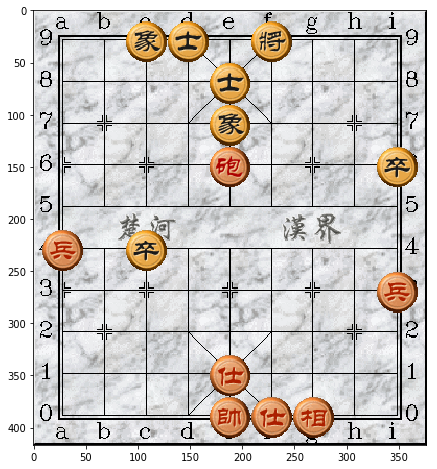

In [282]:
statestr = GameBoard.sim_do_action(move,statestr)
state.do_move(move)
plt.figure(figsize=(8,8))
plt.imshow(board_visualizer.get_board_img(statestr))
print(move)

# analysis

In [246]:
for move in network_player.mcts_policy._root._children:
    node = network_player.mcts_policy._root._children[move]
    print(move,node._n_visits,node._P,node._Q)

a5a4 379 0.29144496 0.17134368139390388
c4b4 6 0.0025253445 -0.042129339029391616
c4d4 73 0.04582867 0.12129726204805856
c4c3 15 0.009773272 0.11362375964721041
e9f9 1 0.004160299 -1.0
e5b5 7 0.0042280313 0.13803476840257645
e5c5 7 0.009751533 -0.02489076607993671
e5d5 188 0.119171776 0.15582039798708983
e5f5 3 0.008787801 -0.19426834334929785
e5g5 5 0.005639106 0.04699916914105415
e5h5 24 0.011198383 0.15421279698299864
e5i5 0 0.00036198218 0
e5e6 26 0.024989149 0.056872706063306695
e5e4 6 0.0050816545 0.09361020227273306
e5e3 13 0.012078651 0.0705103389918804
e5e2 0 0.0005843815 0
e5e1 1 0.0014584941 0.027864200994372368
g3f3 235 0.034386765 0.21378001486238588
g3h3 10 0.00809242 0.08883720254525543
g3g2 77 0.06947285 0.060815426537634
h9f9 46 0.0072261044 0.24695390392013866
h9g9 4 0.0018124854 -0.24550805985927582
h9i9 0 0.00065089134 0
h9h8 23 0.046894178 -0.17562252716363771
h9h7 3 0.0034672315 0.00256421510130167
h9h6 2 0.0054383646 -0.36332716047763824
h9h5 26 0.06318762 -0.226